## Grid World

In [44]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image

In [45]:
# Grid world object and environment class
class gameOb():
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name
        
class gameEnv():
    def __init__(self, partial, size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        self.partial = partial
        a = self.reset()
        plt.imshow(a, interpolation="nearest")
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(), 1, 1, 2, None, 'hero')
        self.objects.append(hero)
        bug = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug)
        hole = gameOb(self.newPosition(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole)
        bug2 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug2)
        hole2 = gameOb(self.newPosition(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole2)
        bug3 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug3)
        bug4 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug4)
        state = self.renderEnv()
        self.state = state
        
        return state
    
    def moveChar(self, direction):
        # 0-up, 1-down, 2-left, 3-right
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        penalize = 0.
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY - 2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX - 2:
            hero.x += 1
        if hero.x == heroX and hero.y == heroY:
            penalize= 0.0
        self.objects[0] = hero
        
        return penalize
    
    def newPosition(self):
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if (objectA.x, objectA.y) not in currentPositions:
                currentPositions.append((objectA.x, objectA.y))
        for pos in currentPositions:
            points.remove(pos)
        location = np.random.choice(range(len(points)), replace = False)
        
        return points[location]
    
    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
                
        ended = False
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(), 1, 1, 1, 1, 'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(), 1, 1, 0, -1, 'fire'))
                return other.reward, False
            
        if ended == False :
            return 0.0, False
        
    def renderEnv(self):
        a = np.ones([self.sizeY + 2, self.sizeX + 2, 3])
        a[1:-1, 1:-1, :] = 0
        hero = None
        for item in self.objects:
            a[item.y+1:item.y+item.size+1, item.x+1:item.x+item.size+1, item.channel] = item.intensity
            if item.name == 'hero':
                hero = item
            
        if self.partial == True:
            a = a[hero.y:hero.y+3, hero.x : hero.x+3, :]
        b = np.array(Image.fromarray(a[:, :, 0]).resize((84, 84), Image.NEAREST)).astype(np.double)
        c = np.array(Image.fromarray(a[:, :, 0]).resize((84, 84), Image.NEAREST)).astype(np.double)
        d = np.array(Image.fromarray(a[:, :, 0]).resize((84, 84), Image.NEAREST)).astype(np.double)
        a = np.stack([b, c, d], axis = 2)
        
        return a
    
    def step(self, action):
        penalty = self.moveChar(action)
        reward, done = self.checkGoal()
        state = self.renderEnv()
        if reward == None:
            print(done)
            print(reward)
            print(penalty)
            return state, (reward+penalty), done
        else:
            return state, (reward+penalty), done  

## Double Dueling DQN

In [46]:
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

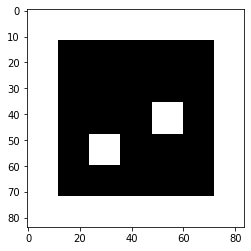

In [47]:
env = gameEnv(partial = False, size = 5)

In [48]:
# Q-Network
class Qnetwork():
    def __init__(self, h_size):
        # Network input one frame and convert into array
        # resize array and forward to 4 conv network
        self.scalarInput = tf.placeholder(shape=[None, 21168], dtype = tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape = [-1, 84, 84, 3])
        self.conv1 = slim.conv2d(inputs = self.imageIn, num_outputs = 32, kernel_size = [8, 8], stride = [4, 4],
                                padding = 'VALID', biases_initializer = None)
        self.conv2 = slim.conv2d(inputs = self.conv1, num_outputs = 64, kernel_size = [4, 4], stride = [2, 2],
                                padding = 'VALID', biases_initializer = None)
        self.conv3 = slim.conv2d(inputs = self.conv2, num_outputs = 64, kernel_size = [3, 3], stride = [1, 1],
                                padding = 'VALID', biases_initializer = None)
        self.conv4 = slim.conv2d(inputs = self.conv3, num_outputs = h_size, kernel_size = [7, 7], stride = [1, 1],
                                padding = 'VALID', biases_initializer = None)
        
        # split output into advantage stream and value stream
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        # to get final Q-value, combine advantage stream and value stream
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis = 1, keep_dims = True))
        self.predict = tf.argmax(self.Qout, 1)
        
        # get cost by computing sum(target_Q-value - predict_Q-value)^2
        self.targetQ = tf.placeholder(shape = [None], dtype = tf.float32)
        self.actions = tf.placeholder(shape = [None], dtype = tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype = tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis = 1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate = 0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
# restore experience and sample and train network randomly
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size :
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])
    
# resize size of frame
def processState(states):
    return np.reshape(states, [21168])

# update target network parameters according to 1-dim network parameters
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx, var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx + total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx + total_vars//2].value())))
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)
        


In [49]:
# set parameters for training
batch_size = 32
updae_freq = 4
y = .99
startE = 1
endE = 0.1
anneling_steps = 10000
num_episodes = 10000
pre_train_steps = 10000
max_epLength = 50
load_model = False
path = './dqn'
h_size = 512
tau = 0.001

tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)
myBuffer = experience_buffer()

# set decreasing ratio of random action
e = startE
stepDrop = (startE - endE)/anneling_steps

# create list which append total reward and num of steps per episode
jList = []
rList = []
total_steps = 0

# path to save model
if not os.path.exists(path):
    os.makedirs(path)
    
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    updateTarget(targetOps, sess)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        # Q-Network
        while j < max_epLength:
            j += 1
            if np.random.rand(1)< e or total_steps < pre_train_steps:
                a = np.random.randint(0, 4)
            else:
                a = sess.run(mainQN.predict, feed_dict = {mainQN.scalarInput:[s]})[0]
            s1, r, d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            
            episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                    
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size)
                    Q1 = sess.run(mainQN.predict, feed_dict = {mainQN.scalarInput:np.vstack(trainBatch[:, 3])})
                    Q2 = sess.run(targetQN.Qout, feed_dict = {targetQN.scalarInput:np.vstack(trainBatch[:, 3])})
                    end_multiplier = -(trainBatch[:, 4] -1)
                    doubleQ = Q2[range(batch_size), Q1]
                    targetQ = trainBatch[:, 2] + (y * doubleQ * end_multiplier)
                    
                    _ = sess.run(mainQN.updateModel, feed_dict = {mainQN.scalarInput:np.vstack(trainBatch[:, 0]),
                                                                 mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:, 1]})
                    updateTarget(targetOps, sess)
                
            rAll += r
            s = s1
                
            if d == True:
                break
                    
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
            
        if i % 1000 == 0 :
            saver.save(sess, path + '/model-' + str(i) + '.cptk')
            print("Saved Model")
                
        if len(rList) % 10 == 0:
            print(total_steps, np.mean(rList[-10:]), e)
        saver.save(sess, path + '/model-' + str(i) + '.cptk')
            
    print("Percent of successful episodes : " + str(sum(rList)/num_episodes))

Saved Model
500 4.5 1
1000 2.9 1
1500 1.5 1
2000 2.3 1
2500 3.3 1
3000 1.7 1
3500 2.3 1
4000 1.8 1
4500 2.4 1
5000 3.3 1
5500 2.4 1
6000 2.1 1
6500 1.7 1
7000 2.4 1
7500 2.1 1
8000 3.6 1
8500 2.9 1
9000 2.8 1
9500 2.0 1
10000 1.5 1
10500 1.8 0.9549999999999828
11000 3.0 0.9099999999999655
11500 2.4 0.8649999999999483
12000 1.7 0.819999999999931
12500 1.1 0.7749999999999138
13000 1.3 0.7299999999998965
13500 1.3 0.6849999999998793
14000 2.1 0.639999999999862
14500 0.8 0.5949999999998448
15000 1.7 0.5499999999998275
15500 2.1 0.5049999999998103
16000 0.7 0.4599999999998177
16500 2.0 0.41499999999982823
17000 0.8 0.36999999999983874
17500 1.2 0.32499999999984924
18000 -0.1 0.27999999999985975
18500 0.5 0.23499999999986562
19000 0.9 0.18999999999986225
19500 0.6 0.14499999999985888
20000 0.4 0.09999999999985551
20500 0.9 0.09999999999985551
21000 0.3 0.09999999999985551
21500 0.4 0.09999999999985551
22000 -0.1 0.09999999999985551
22500 0.4 0.09999999999985551
23000 0.5 0.09999999999985551


84000 0.1 0.09999999999985551
84500 0.2 0.09999999999985551
85000 0.1 0.09999999999985551
85500 -0.1 0.09999999999985551
86000 -0.2 0.09999999999985551
86500 0.9 0.09999999999985551
87000 0.5 0.09999999999985551
87500 0.6 0.09999999999985551
88000 1.1 0.09999999999985551
88500 0.6 0.09999999999985551
89000 0.1 0.09999999999985551
89500 0.1 0.09999999999985551
90000 0.3 0.09999999999985551
90500 0.6 0.09999999999985551
91000 0.8 0.09999999999985551
91500 0.7 0.09999999999985551
92000 -0.1 0.09999999999985551
92500 0.0 0.09999999999985551
93000 0.5 0.09999999999985551
93500 1.0 0.09999999999985551
94000 0.3 0.09999999999985551
94500 0.6 0.09999999999985551
95000 0.8 0.09999999999985551
95500 -0.2 0.09999999999985551
96000 0.6 0.09999999999985551
96500 0.0 0.09999999999985551
97000 1.0 0.09999999999985551
97500 0.4 0.09999999999985551
98000 0.8 0.09999999999985551
98500 0.7 0.09999999999985551
99000 0.5 0.09999999999985551
99500 0.3 0.09999999999985551
100000 0.6 0.09999999999985551
Saved

216000 0.1 0.09999999999985551
216500 -0.2 0.09999999999985551
217000 0.5 0.09999999999985551
217500 -0.1 0.09999999999985551
218000 0.3 0.09999999999985551
218500 -0.1 0.09999999999985551
219000 0.4 0.09999999999985551
219500 0.3 0.09999999999985551
220000 0.2 0.09999999999985551
220500 0.2 0.09999999999985551
221000 0.1 0.09999999999985551
221500 0.8 0.09999999999985551
222000 0.4 0.09999999999985551
222500 0.3 0.09999999999985551
223000 0.0 0.09999999999985551
223500 0.1 0.09999999999985551
224000 0.1 0.09999999999985551
224500 0.3 0.09999999999985551
225000 0.2 0.09999999999985551
225500 0.1 0.09999999999985551
226000 0.6 0.09999999999985551
226500 0.7 0.09999999999985551
227000 0.9 0.09999999999985551
227500 0.5 0.09999999999985551
228000 0.1 0.09999999999985551
228500 0.5 0.09999999999985551
229000 0.3 0.09999999999985551
229500 0.5 0.09999999999985551
230000 -0.1 0.09999999999985551
230500 0.3 0.09999999999985551
231000 0.1 0.09999999999985551
231500 0.5 0.09999999999985551
2320

347500 -0.2 0.09999999999985551
348000 0.2 0.09999999999985551
348500 0.0 0.09999999999985551
349000 0.3 0.09999999999985551
349500 -0.1 0.09999999999985551
350000 0.9 0.09999999999985551
Saved Model
350500 0.8 0.09999999999985551
351000 0.5 0.09999999999985551
351500 -0.5 0.09999999999985551
352000 0.4 0.09999999999985551
352500 0.9 0.09999999999985551
353000 0.7 0.09999999999985551
353500 0.4 0.09999999999985551
354000 0.2 0.09999999999985551
354500 0.3 0.09999999999985551
355000 0.9 0.09999999999985551
355500 0.5 0.09999999999985551
356000 0.4 0.09999999999985551
356500 0.5 0.09999999999985551
357000 0.4 0.09999999999985551
357500 0.6 0.09999999999985551
358000 0.5 0.09999999999985551
358500 0.7 0.09999999999985551
359000 0.6 0.09999999999985551
359500 -0.2 0.09999999999985551
360000 -0.4 0.09999999999985551
360500 0.1 0.09999999999985551
361000 0.6 0.09999999999985551
361500 -0.2 0.09999999999985551
362000 0.4 0.09999999999985551
362500 0.4 0.09999999999985551
363000 0.7 0.09999999

478500 -0.2 0.09999999999985551
479000 0.1 0.09999999999985551
479500 0.5 0.09999999999985551
480000 0.2 0.09999999999985551
480500 0.4 0.09999999999985551
481000 0.8 0.09999999999985551
481500 -0.1 0.09999999999985551
482000 -0.3 0.09999999999985551
482500 1.8 0.09999999999985551
483000 0.4 0.09999999999985551
483500 0.8 0.09999999999985551
484000 0.2 0.09999999999985551
484500 0.6 0.09999999999985551
485000 0.5 0.09999999999985551
485500 0.3 0.09999999999985551
486000 -0.2 0.09999999999985551
486500 0.6 0.09999999999985551
487000 0.2 0.09999999999985551
487500 -0.1 0.09999999999985551
488000 0.0 0.09999999999985551
488500 0.4 0.09999999999985551
489000 0.5 0.09999999999985551
489500 0.5 0.09999999999985551
490000 0.5 0.09999999999985551
490500 1.0 0.09999999999985551
491000 0.4 0.09999999999985551
491500 0.2 0.09999999999985551
492000 0.7 0.09999999999985551
492500 0.0 0.09999999999985551
493000 0.0 0.09999999999985551
493500 0.6 0.09999999999985551
494000 -0.3 0.09999999999985551
49

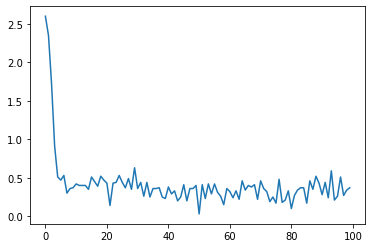

In [50]:
rMat = np.resize(np.array(rList), [len(rList)//100, 100])
rMean = np.average(rMat, 1)
plt.plot(rMean)